In [59]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import minimize

# Additions: sigma_x, generate_spins;
#            sigma_z in progress

# Problems: sigma_z (works only for n = 2), show_psi could be nicer
# Find the exact solution by hand

class Boltznann_two_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian, n = 2):
        self.n = n
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W      
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
        
    ########### PSI #################################
    
    def psi_M(self, S, w):    # Works for complex w, however, runtime errors
        """Returns a component of a wavefunction
        in the S direction
        psi is given in form of an array and works for any number of spins"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
#         print('W ===', len(W))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi

    def compute_psi(self, w):
        """Computes psi for w = a,b,W 
        psi is given in form of an array and works for any number of spins"""
        n = len(w[0])
        s = generate_spins(n)
        psi = np.zeros(2 ** n, dtype = 'complex')
        for i in range(len(psi)):
            psi[i] = self.psi_M(s[i], w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
#         return psi / np.sqrt(np.sum(np.dot(psi, psi)))
        psi_star = np.transpose(np.conjugate(psi))
#         return psi / np
        return psi / np.sqrt(np.sum(psi_star @ psi))
        
    def show_psi(self, psi):
        """psi is a vector with lenght 2^n"""
        s = 'psi = '
        print(len(psi))
        for i in range(len(psi)):
            basis = bin(i)
            while len(basis) < len(bin(len(psi))) - 1:
                basis = basis[0:2] + '0' + basis[2:]
            s += str('%.5f' % np.real(psi[i])) + ' + i' + str('%.5f' % np.imag(psi[i])) + '|' + basis[2:] + '>' + ' + '
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** l != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) # w_scipy = [real(a[0]), imag(a[0]), real(a[1]), ...]
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
        <E> = <psi|H|psi> / <psi|psi>"""
        psi_star = np.transpose(np.conjugate(psi))
#         print('PsiPsi = ', np.sum(psi_star * psi))
#         print('PsiHPsi = ', np.sum(psi_star * self.hamiltonian(psi)))
#         self.hamiltonian(psi)
        return np.sum(psi_star * self.hamiltonian(psi)) / np.sum(psi_star * psi)
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
#         print('Entered')
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
#         print('Computed')
        return np.real(self.avg_energy(psi))
#         return self.avg_energy(psi)
    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
        w_min = minimize(self.avg_energy_scipy, w0_scipy)    # x0 is now complex, size 2N, even spots real, odd imag
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)    # w_optimal is in a, b, W form
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

########### OLD HAMILTONIAN #########################

# def sigma_x(psi):
#     """Applies sum sigma_x_i on a given 
#     wavefunction psi and returns the 
#     new wavefunciton"""
#     psi1 = np.zeros((len(psi), len(psi)), dtype = 'complex')
#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[(i + 1) % 2, j] += psi[i, j]
#             psi1[i, (j + 1) % 2] += psi[i, j]
#     return psi1

def sigma_z(psi):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    psi1 = np.zeros((len(psi), len(psi)), dtype = 'complex')
    for i in range(len(psi)):
        for j in range(len(psi[i])):
            psi1[i, j] = (-1) ** (i + j) * psi[i, j]
    return psi1

def hamiltonian(psi):
    """Retuns wave function after the TFI Hamiltonian 
    acts on it, with h = 1 (to be modified later)"""
    return h * sigma_x(psi) + sigma_z(psi)

########### OLD HAMILTONIAN #########################

########### NEW HAMILTONIAN #########################

def find_len_a(N):
    """Returns the size of a for a given length 
    N of w = a,b,W in a form of 1D array"""
    l = 0
    while 2 * l + l ** l != N:
        l += 1
        print(2 * l + l ** l)
    return l

def sigma_x(psi):
    """Applies sum sigma_x_i on a given 
    wavefunction psi (in form of 1D array) and returns the 
    new wavefunciton psi1"""
    n = len(psi)
    psi1 = np.zeros((n), dtype = 'complex')
    for i in range(n):
        # s = 1001 meaning |1001>, iterates through all the possible states 001, 010, 011 ...
        s = bin(i)
        # instead of i = 1 ==> b = 0b1, we want b = 0b001, for 3 spins
        while len(s) < len(bin(n)) - 1:
            s = s[0:2] + '0' + s[2:]
        for j in range(len(s[2:])):
            s1 = ''    # flipping all the possible bits once; 101 would give s1: 100, 111, 001
            for k in s:    # constructing s1 as a function of j               j:  0,   1,   2
                if j - 1 == len(s[2:]) - len(s1):
                    if k == '0':
                        s1 += '1'
                    else:
                        s1 += '0'
                else:
                    s1 += k
            i1 = int(s1, 2)
#             print(s, s1)
#             print(i, i1)
            psi1[i1] += psi[i]
    return psi1
    
def double_sigma_z(psi):#Change the sigma for the larger n
    """Applies  sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
#     print('Entered sigma_z')
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    for i in range(len(psi)):
        psi_sigma_z[i] = psi[i]
    n = len(psi)
    n_spins = int(np.log2(n)) #number of particl
    s = generate_spins(n_spins)
    for i in range(n):     
        for j in range(n_spins):
            if s[i,j]== -1:
                psi_sigma_z[i] *= (-1)
#     print(psi_sigma_z)
    return psi_sigma_z

def hamiltonian(psi):
    """Retuns wave function after the TFI Hamiltonian 
    acts on it, with h = 1 (to be modified later)"""
#     return h * sigma_x(psi)
    return h * sigma_x(psi) + double_sigma_z(psi)

def generate_spins(n):
    s = np.zeros((2 ** n, n))
    for i in range(2 ** n):
        b = bin(i)
        while len(b) < n + 2:
            b = b[0:2] + '0' + b[2:]
        d = []
        for k in b:
            if k == '0':
                d.append(-1)
#                     d.append(0)    # This could be more convenient, we'll see
            else:
                d.append(1)
        s[i] = np.array(d[2:])
    return s
    
#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[i, j] = (-1) ** (i + j) * psi[i, j]
#     return psi1


#     for i in range(len(psi)):
#         for j in range(len(psi[i])):
#             psi1[(i + 1) % 2, j] += psi[i, j]
#             psi1[i, (j + 1) % 2] += psi[i, j]
#     return psi1

########### NEW HAMILTONIAN #########################


In [60]:
########### INITIALIZATION ########################

a = np.array((1 + 1j, 5 + 3j))
b = np.array((2 + 4j, 3 + 7j))
W = np.random.rand(2,2) + 1j * np.random.rand(2,2)
# a = np.array((1, 1)) * 0.001
# b = np.array((1, 1)) * 0.001
# W = np.random.rand(2,2) * 0.001
w = a, b, W
h = 0.1
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################

psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)
psi_sigma_z = double_sigma_z(psi)
boltzmann.show_psi(psi_sigma_z)

4
psi = 0.00702 + i-0.07952|00> + 5232.46313 + i1598.80349|01> + -3.78306 + i1.29392|10> + -15368.55199 + i-288280.21610|11>
4
psi = 0.00702 + i-0.07952|00> + -5232.46313 + i-1598.80349|01> + 3.78306 + i-1.29392|10> + -15368.55199 + i-288280.21610|11>


In [64]:
########### INITIALIZATION ########################

# a = np.array((1 + 1j, 5 + 3j))
# b = np.array((2 + 4j, 3 + 7j))
# W = np.random.rand(2,2) + 1j * np.random.rand(2,2)
a = np.array((0, 1))
b = np.array((1, 1))
a = np.random.rand(2)
b = np.random.rand(2)
W = np.random.rand(2,2)
w = a, b, W
h = 0.5
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################
########### OPTIMZATION ###########################

boltzmann.find_optimal_psi(w)

########### OPTIMZATION ###########################
########### EXTRACTING PARAMETERS #################

w_optimal = boltzmann.w_optimal
psi_optimal = boltzmann.psi_optimal
min_energy = boltzmann.min_energy

########### EXTRACTING PARAMETERS #################

In [65]:
boltzmann.show_psi_optimal()
boltzmann.show_min_energy()
boltzmann.show_omega_optimal()

4
psi = 10.43236 + i0.00002|00> + 8.88113 + i-0.00000|01> + 31.70928 + i-0.00001|10> + 12248526.76516 + i-24.98863|11>
E_min = (1.000003313889457+1.4775569702949302e-22j)
a =  [2.45950754-5.40373596e-07j 2.00793014-4.82868856e-07j] 
b =  [1.22653548-6.00511725e-07j 1.2951454 -1.50249117e-07j] 
W =  [[2.66750325+2.03757306e-08j 1.86410585-3.78581937e-07j]
 [2.13267027+7.16806706e-08j 2.66750325+2.03757306e-08j]]


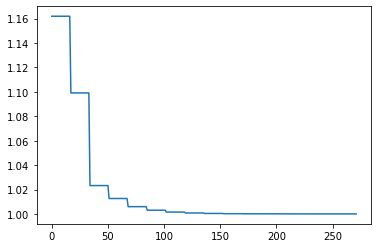

In [66]:
plt.plot(np.real(boltzmann.energy_optimization_history))

In [37]:
########### INITIALIZATION ########################

# a = np.array((1 + 1j, 5 + 3j)) * 0.001
# b = np.array((2 + 4j, 3 + 7j)) * 0.001
# W = np.random.rand(2,2) + 1j * np.random.rand(2,2) * 0.001
a = np.array((1, 1))
b = np.array((1, 1))
W = np.random.rand(2,2)
a = np.array((1, 0))
b = np.array((0, 0))
# W = np.random.rand(2,2)
W = np.array(([0, 0], [0, 0]))
w = a, b, W
h = 0.1
n = 2
s = generate_spins(2)
boltzmann = Boltznann_two_spins(hamiltonian, n)

########### INITIALIZATION ########################
# ########### OPTIMZATION ###########################

# boltzmann.find_optimal_psi(w)

# ########### OPTIMZATION ###########################
# ########### EXTRACTING PARAMETERS #################

# w_optimal = boltzmann.w_optimal
# psi_optimal = boltzmann.psi_optimal
# min_energy = boltzmann.min_energy

# ########### EXTRACTING PARAMETERS #################

In [ ]:
# psi = boltzmann.compute_psi(s, a, b, w, n)
psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)
# boltzmann.show_min_energy()
# boltzmann.show_omega_optimal()

In [ ]:

########### INITIALIZATION ########################

# a = np.array((1 + 1j, 5 + 3j)) * 0.001
# b = np.array((2 + 4j, 3 + 7j)) * 0.001
# W = np.random.rand(2,2) + 1j * np.random.rand(2,2) * 0.001
a = np.array((1, 0))
b = np.array((0, 0))
# W = np.random.rand(2,2)
W = np.array(([0, 0], [0, 0]))
w = a, b, W
h = 0.1
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################

In [ ]:
psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)

In [ ]:
########### INITIALIZATION ########################

# a = np.array((1 + 1j, 5 + 3j)) * 0.001
# b = np.array((2 + 4j, 3 + 7j)) * 0.001
# W = np.random.rand(2,2) + 1j * np.random.rand(2,2) * 0.001
a = np.array((0, 0))
b = np.array((0, 0))
# W = np.random.rand(2,2)
W = np.array(([1, 1], [0, 0]))
w = a, b, W
h = 0.1
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################

In [ ]:
psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)

In [67]:
########### INITIALIZATION ########################

# a = np.array((1 + 1j, 5 + 3j)) * 0.001
# b = np.array((2 + 4j, 3 + 7j)) * 0.001
# W = np.random.rand(2,2) + 1j * np.random.rand(2,2) * 0.001
a = np.array((1, 0, 1))
b = np.array((0, 0, 0))
# W = np.random.rand(2,2)
W = np.array(([0, 0, 0], [0, 0, 0], [0, 0, 0]))
w = a, b, W
h = 0.1
boltzmann = Boltznann_two_spins(hamiltonian)

########### INITIALIZATION ########################

In [69]:
psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)
psi_normalized = boltzmann.normalize(psi)
boltzmann.show_psi(psi_normalized)
s = np.sum(psi_normalized**2)
print(s)

8
psi = 1.08268 + i0.00000|000> + 8.00000 + i0.00000|001> + 1.08268 + i0.00000|010> + 8.00000 + i0.00000|011> + 8.00000 + i0.00000|100> + 59.11245 + i0.00000|101> + 8.00000 + i0.00000|110> + 59.11245 + i0.00000|111>
8
psi = 0.01272 + i0.00000|000> + 0.09398 + i0.00000|001> + 0.01272 + i0.00000|010> + 0.09398 + i0.00000|011> + 0.09398 + i0.00000|100> + 0.69439 + i0.00000|101> + 0.09398 + i0.00000|110> + 0.69439 + i0.00000|111>
(0.9999999999999998+0j)


In [ ]:
n = 2
w = np.random.rand(n, n)
print(w)

In [ ]:
a = np.random.rand(3,3)
b = np.random.rand(3,3)
print(a)
print(b)
np.dot(a, b)